## Imports [ together with importing the generator function from generator.py ]

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from random import randint
from skimage.transform import radon

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.cluster import KMeans
from kmeans_pytorch import kmeans






# Our generator file 
from generator import single_square_data_generator, \
                      square_data_generator, \
                      sinogram_fnc, \
                      visualize

### Generate some data, visualize, check shapes - the usual stuff  :

In the CNN_paper they generate 9000 examples, but their data is more complex, so 2000 samples should be enough 
* Especially since here we don't rotate right ? So data is super simple   

In [10]:
sinograms, images, angles = square_data_generator(n = 100, img_size = 91)

In [11]:
print("sinograms.shape : {}".format(sinograms.shape))
print("images.shape : {}".format(images.shape))

sinograms.shape : torch.Size([100, 1, 91, 180])
images.shape : (100, 91, 91)


In [12]:
sinogram = sinograms[0]
image = images[0]

print("sinogram.shape : {}".format(sinogram.shape))
print("image.shape : {}".format(image.shape))

sinogram.shape : torch.Size([1, 91, 180])
image.shape : (91, 91)


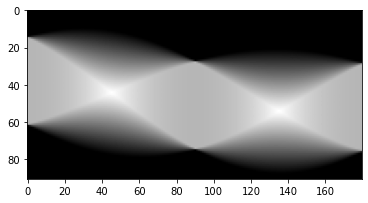

In [13]:
visualize(sinogram[0])

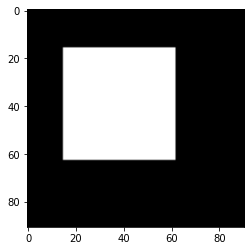

In [14]:
visualize(image)

## Model time 

In [19]:
class CNN(nn.Module):
    def __init__(self, img_size = 91, chan1 = 5, chan2 = 10, chan3 = 15) :
        super(CNN, self).__init__()
        
        self.final_img_size = int(((img_size-4)//3 - 2) //3 - 2)
        
        
        self.conv1 = nn.Conv2d(1, chan1, 5)
        self.conv2 = nn.Conv2d(chan1, chan2, 3)
        self.conv3 = nn.Conv2d(chan2, chan3, 3)
        self.pool = nn.MaxPool2d(3,3) 
        
        self.fc1 = nn.Linear(15 * 16  * self.final_img_size ,500) # what's the first thing coming in ?
        self.fc2 = nn.Linear(500,180) # sigmoid act ! 
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self,x) :
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # x = self.pool(x)
        
        
        # 16 is what 180 becomes after all the operations, if we apply 1 more maxpool(3,3) at the end we 180 becomes 5 instead
        # 15 is the number of channels [ chan3 ! ]
        
        x = x.view(-1, 15 * 16 * self.final_img_size)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x)) # SIGMOID ! 
        return x
        
        
#So the counting will go sth like this 
# Conv2d(input_chan, output chann) -> The next conv2D has got to have input chan equal to prev output channel
# Count the ending size like this : 
# side_size - kernel_size + 1 -> //2 -> -kernel + 1 -> //2 
# What chan size should be used !?

In [20]:
Net = CNN()

In [56]:
# Here, test the forward function - it should output 180 probabilities 
sinogram, img, angles= square_data_generator(1)

probabilities = Net(sinogram) 
print("probabilities.shape : {}".format(probabilities.shape))

probabilities.shape : torch.Size([1, 180])


In [57]:
def threshold_act_and_kmeans(probabilities, # [1,180] probabilities from 1 image input
                             threshold = 0.55,
                             clusters_nr = 2) -> "outputs a list of 2/3/4 cluster centers" :
    
    
    # Choose all of the x-rays over certain "threshold"
    x_ray_list = []
    for counter, probability in enumerate(probabilities[0]):   # Because probabilities is 2d array in shape [1,180]
        if probability >= threshold :
            projection = sinogram[0, 0, :, counter]
            x_ray_list.append(projection)
    
    # Chnage our list of tensors into one tensor using torch's stack fnc
    x_ray_list = torch.stack(x_ray_list)

    # kmeans [ the github implementation ]
    cluster_ids_x, cluster_centers = kmeans(X = x_ray_list, num_clusters = clusters_nr, distance = 'euclidean' )

    return cluster_centers

In [58]:
output_angles = threshold_act_and_kmeans(probabilities)
print("\noutput_angles.shape : {}".format(output_angles.shape)) 

[running kmeans]: 2it [00:00, 362.34it/s, center_shift=0.000000, iteration=2, tol=0.000100]

running k-means on cpu..

output_angles.shape : torch.Size([2, 91])


# We got our output - now calculate the loss ! 

In [55]:
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr=0.001)

In [60]:
# The problem is how exactly do we calculate the loss ? ?
# And whether k-means should be part of forward function in the net ? ?

# 

array([[ 0, 90]])

## Define reconstruction function !!! 

## Some notes & to-dos 

->Make sure everyhing is in tensors ! Send numpy arrays to tensors ! [ otherwise the backprob wont work properly ! ] 

->Is the generator allright? I mean, it's so random? Shouldn't it be more like a square with some white elements within in ? 

->Why do we use sigmoid ? Instead of Softmax? Softmax would give us probabilities over all of these ! 

->Do we need to convert y[ img in generator]  to tensor as well? Probs yes so we use GPU to calculate Cross Entropy loss ?

->What about normalizing in generator and batch norm layers ? 
The paper is from 2019, the batch norm has been popular since 2018, so maybe they skipped it on purpose ? 

->We have to add reconstruction and k-means within the model if we want to feed the batches into it, otherwise we get couple of sinograms but only 1 outputs probabilites, which just doesnt make sense ! 

->Idea for optimization, as we learn more, we could increase the threshold becaue the model should be more sure about its decisions ??

In [1]:
from generator import single_square_data_generator, \
                      square_data_generator, \
                      sinogram_fnc, \
                      visualize



5
